In [37]:
import wmi
import psutil
import pandas as pd
import datetime
import time

# Settings
duration_minutes = 10
sampling_rate_hz = 1
num_samples = duration_minutes * 60 * sampling_rate_hz

# Initialize lists to store data
timestamps = []
cpu_temperatures = []
cpu_usages = []
cpu_loads = []
memory_usages = []
battery_levels = []
cpu_powers = []

# Start time
start_time = datetime.datetime.now()

# Initialize WMI client
w = wmi.WMI(namespace="root\\OpenHardwareMonitor")

# Collect data
for i in range(num_samples):
    try:
        # Get current time
        current_time = datetime.datetime.now()
        timestamps.append(current_time)
        
        # Get CPU temperature
        sensor_info = w.Sensor()
        cpu_temp = None
        cpu_power = None
        
        for sensor in sensor_info:
            if sensor.SensorType == 'Temperature' and 'CPU' in sensor.Name:
                cpu_temp = sensor.Value
            if sensor.SensorType == 'Power' and 'CPU Package' in sensor.Name:
                cpu_power = sensor.Value
                
        cpu_temperatures.append(cpu_temp)
        cpu_powers.append(cpu_power)
        
        # Get CPU usage
        cpu_usage = psutil.cpu_percent(interval=1/sampling_rate_hz)
        cpu_usages.append(cpu_usage)
        
        # Get CPU load (1 minute average)
        cpu_load = psutil.getloadavg()[0]
        cpu_loads.append(cpu_load)
        
        # Get memory usage
        memory_usage = psutil.virtual_memory().percent
        memory_usages.append(memory_usage)
        
        # Get battery level
        battery = psutil.sensors_battery()
        battery_level = battery.percent if battery else None
        battery_levels.append(battery_level)
        
    except Exception as e:
        print(f"Error collecting data: {e}")
        cpu_temperatures.append(None)
        cpu_usages.append(None)
        cpu_loads.append(None)
        memory_usages.append(None)
        battery_levels.append(None)
        cpu_powers.append(None)
    
    # Wait for the next sample
    time.sleep(1 / sampling_rate_hz)

# Create DataFrame
data = {
    'timestamp': timestamps,
    'cpu_temperature': cpu_temperatures,
    'cpu_usage': cpu_usages,
    'cpu_load': cpu_loads,
    'memory_usage': memory_usages,
    'battery_level': battery_levels,
    'cpu_power': cpu_powers
}

df_real = pd.DataFrame(data)

df_real.head()


,timestamp,cpu_temperature,cpu_usage,cpu_load,memory_usage,battery_level,cpu_power
0,2024-07-23 19:54:35.941578,57.0,93.1,1.61,48.8,86,8.462047
1,2024-07-23 19:54:39.007098,70.0,84.6,1.61,49.0,86,15.345071
2,2024-07-23 19:54:42.141491,60.0,84.1,1.48,48.6,86,10.895132
3,2024-07-23 19:54:45.323709,64.0,87.5,1.36,49.0,86,10.814933
4,2024-07-23 19:54:48.390368,60.0,88.8,1.36,48.7,86,10.908710


In [38]:
df_real.to_csv(r'C:\Users\CH\Desktop\practice codes\original_sensor.csv', index=False)

In [1]:
import pandas as pd

# Load the real data
df_real = pd.read_csv(r'C:\Users\CH\Desktop\practice codes\original_sensor.csv', parse_dates=['timestamp'])

# Exclude the 'timestamp' column and describe the remaining columns
df_real_numeric = df_real.select_dtypes(include=[float, int])  # Select only numeric columns
description = df_real_numeric.describe()

# Display the descriptive statistics
description

,cpu_temperature,cpu_usage,cpu_load,memory_usage,battery_level,cpu_power
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,74.906667,84.946500,2.087283,52.086333,84.343333,18.107824
std,10.077229,6.953839,0.553621,4.817703,4.036411,5.188472
min,56.000000,0.200000,0.760000,48.400000,77.000000,3.188134
25%,63.000000,81.800000,1.700000,48.800000,81.000000,12.033618
50%,79.000000,85.300000,2.060000,49.150000,84.000000,20.059191
75%,82.000000,88.700000,2.430000,55.400000,88.000000,21.393425
max,100.000000,96.800000,3.500000,65.600000,91.000000,35.225597


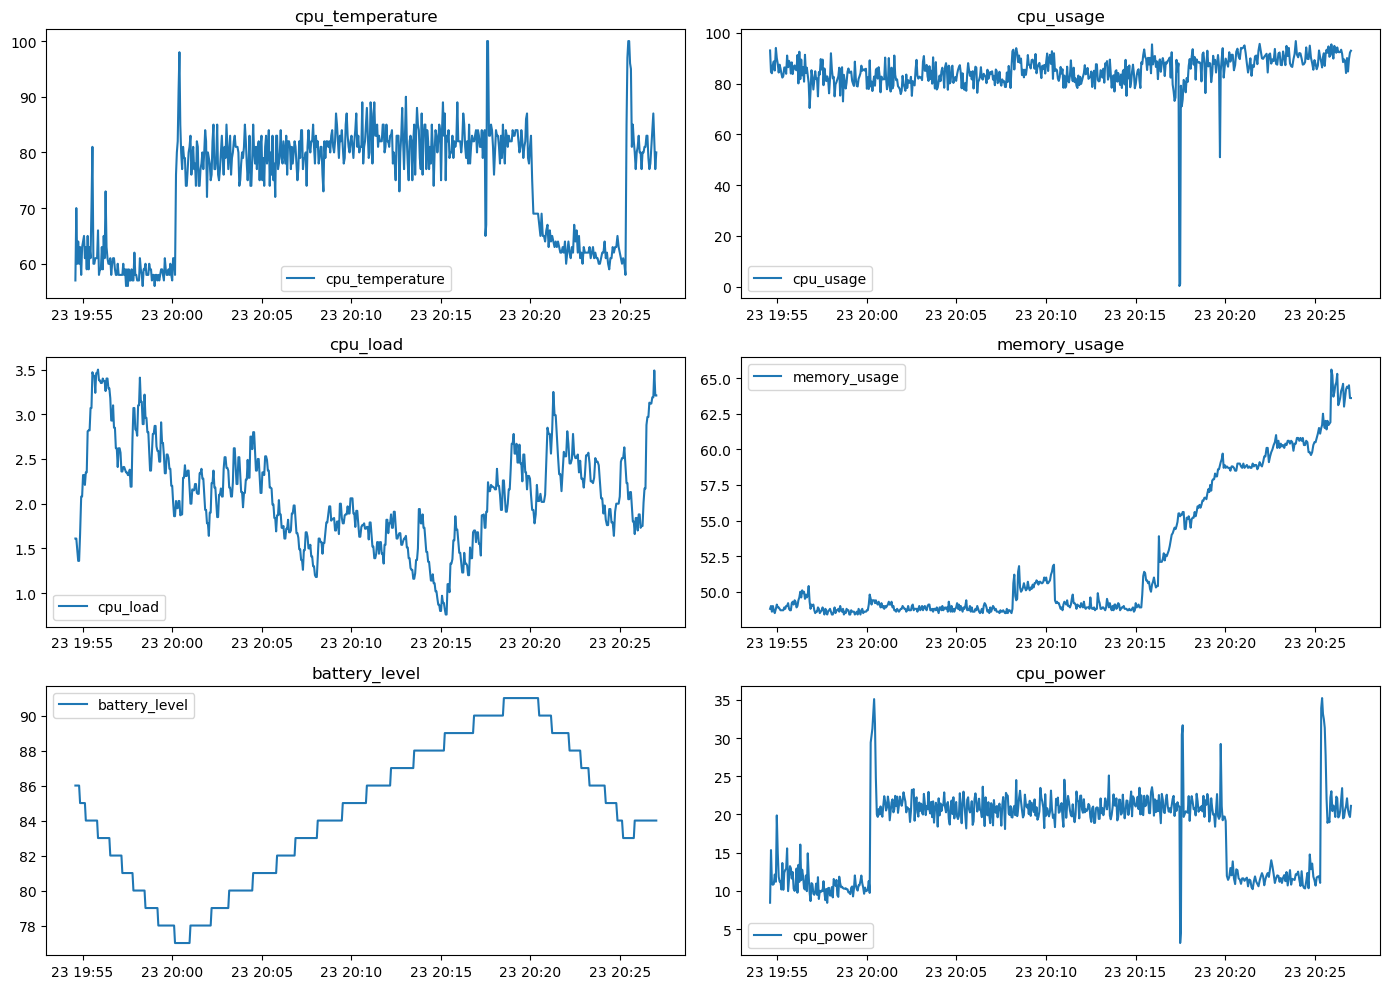

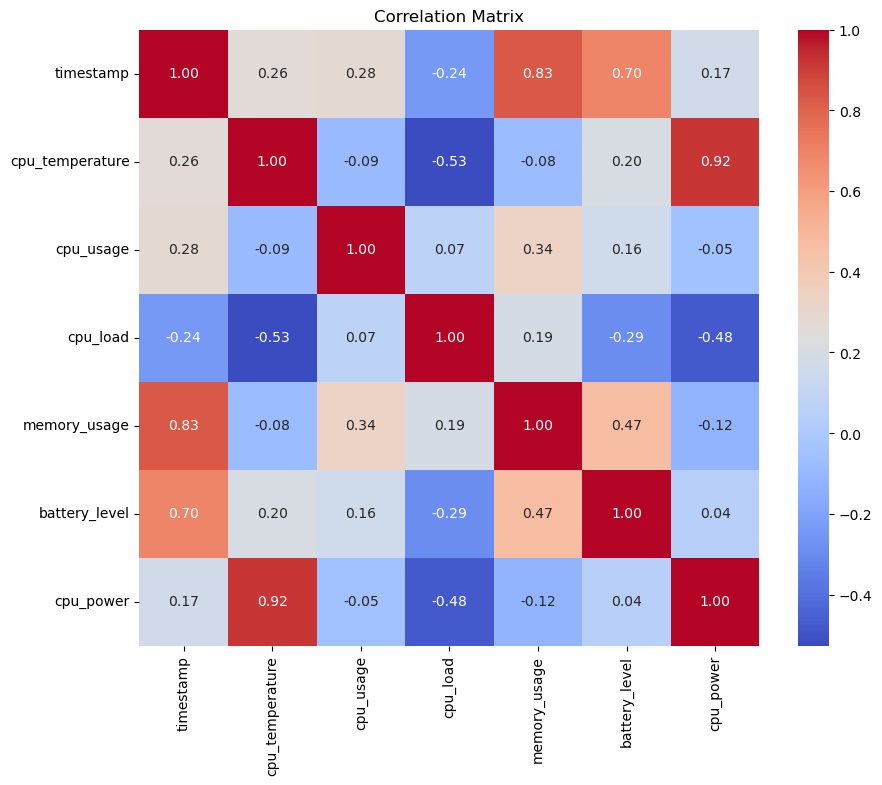

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = r'C:\Users\CH\Desktop\practice codes\original_sensor.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Convert 'timestamp' to datetime format and sort the data by time
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

# Plotting the time series data
plt.figure(figsize=(14, 10))
for i, col in enumerate(df.columns[1:], 1):
    plt.subplot(3, 2, i)
    plt.plot(df['timestamp'].values, df[col].values, label=col)  # Convert to NumPy arrays
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

# Correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


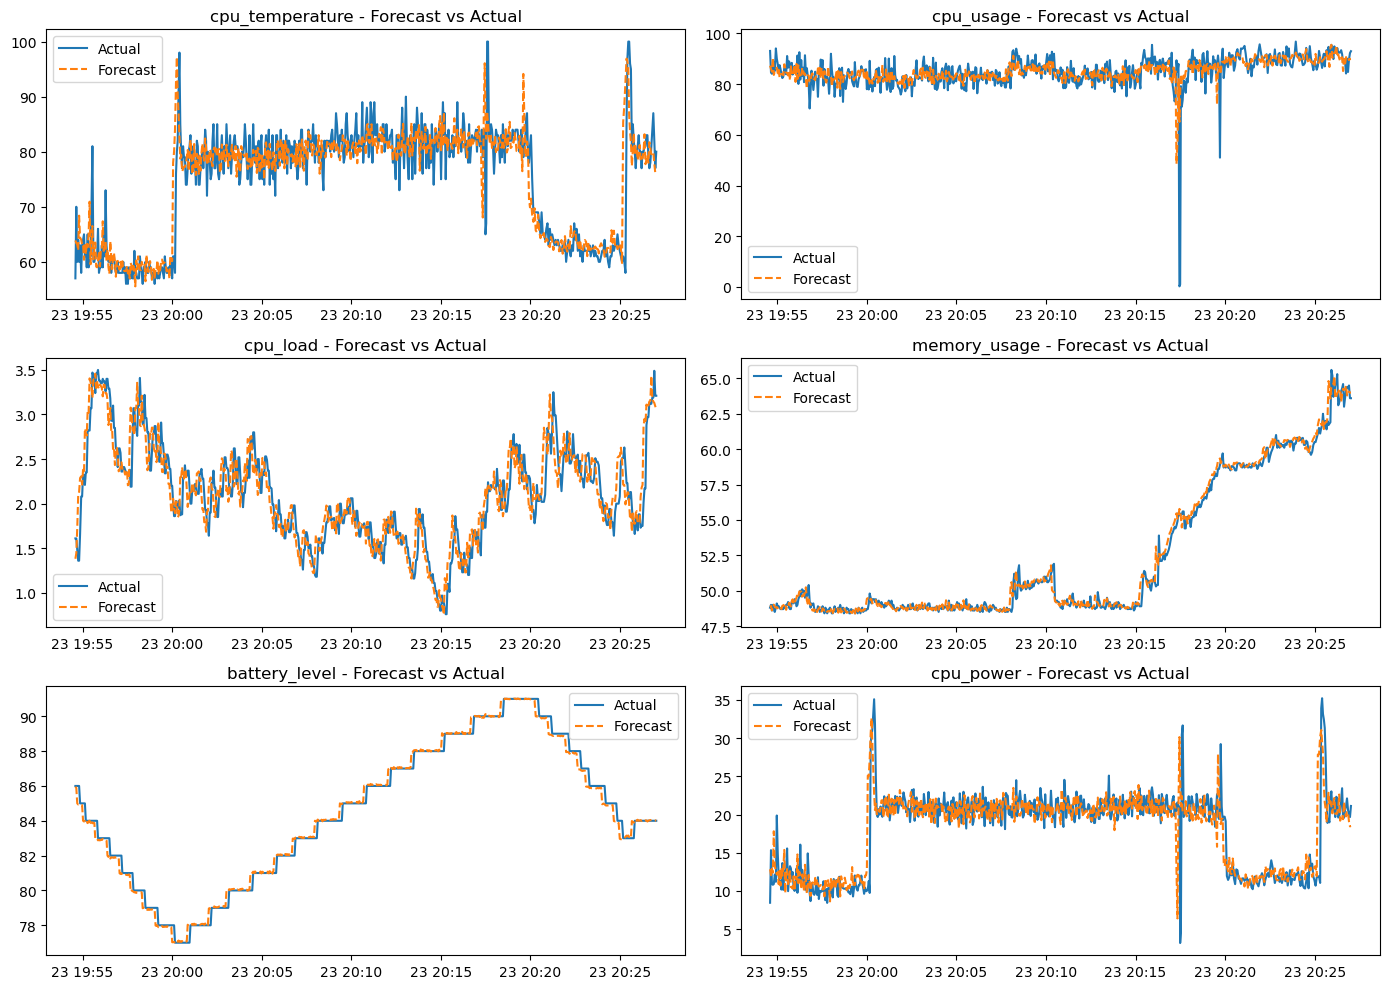

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# Load the dataset
file_path = r'C:\Users\CH\Desktop\practice codes\original_sensor.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Convert 'timestamp' to datetime format and sort the data by time
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

# Selecting relevant columns for the VAR model (excluding timestamp)
data = df[['cpu_temperature', 'cpu_usage', 'cpu_load', 'memory_usage', 'battery_level', 'cpu_power']]

# Fitting the VAR model on the entire dataset
model = VAR(data)
model_fitted = model.fit(maxlags=15, ic='aic')

# In-sample predictions
fitted_values = model_fitted.fittedvalues

# Out-of-sample forecast for the entire dataset
forecast_steps = len(data) - len(fitted_values)
forecast_values = pd.DataFrame(model_fitted.forecast(data.values[-model_fitted.k_ar:], steps=forecast_steps),
                               index=df['timestamp'].values[-forecast_steps:], columns=data.columns)

# Combine in-sample and out-of-sample predictions
full_forecast = pd.concat([fitted_values, forecast_values], axis=0)
full_forecast = full_forecast.set_index(df['timestamp'])

# Plotting the forecasted vs actual values
plt.figure(figsize=(14, 10))
for i, col in enumerate(data.columns, 1):
    plt.subplot(3, 2, i)
    plt.plot(df['timestamp'].values, data[col].values, label='Actual')
    plt.plot(full_forecast.index.to_numpy(), full_forecast[col].values, label='Forecast', linestyle='--')
    plt.title(f'{col} - Forecast vs Actual')
    plt.legend()

plt.tight_layout()
plt.show()

# Save the forecasted DataFrame to a CSV file
full_forecast.to_csv(r'C:\Users\CH\Desktop\practice codes\var_forecast_full_dataset.csv', index=True)

In [3]:
import pandas as pd

# Load the datasets
sensor_data = pd.read_csv(r'C:\Users\CH\Desktop\practice codes\original_sensor.csv', parse_dates=['timestamp'], index_col='timestamp')
var_forecast = pd.read_csv(r'C:\Users\CH\Desktop\practice codes\var_forecast_full_dataset.csv', parse_dates=['timestamp'], index_col='timestamp')


In [4]:
# Align the timestamps between the actual and forecast data
aligned_sensor_data = sensor_data.loc[var_forecast.index]

In [5]:
# Compute residuals
residuals = aligned_sensor_data - var_forecast

In [6]:
# Calculate anomaly scores
anomaly_scores = residuals.abs()

# Determine the threshold (e.g., mean + 3 * std)
threshold = anomaly_scores.mean() + 3 * anomaly_scores.std()

# Identify anomalies
anomalies = anomaly_scores > threshold
anomaly_points = aligned_sensor_data[anomalies.any(axis=1)]

In [7]:
aligned_sensor_data = aligned_sensor_data.loc[var_forecast.index]
anomaly_points = anomaly_points.reindex(aligned_sensor_data.index)

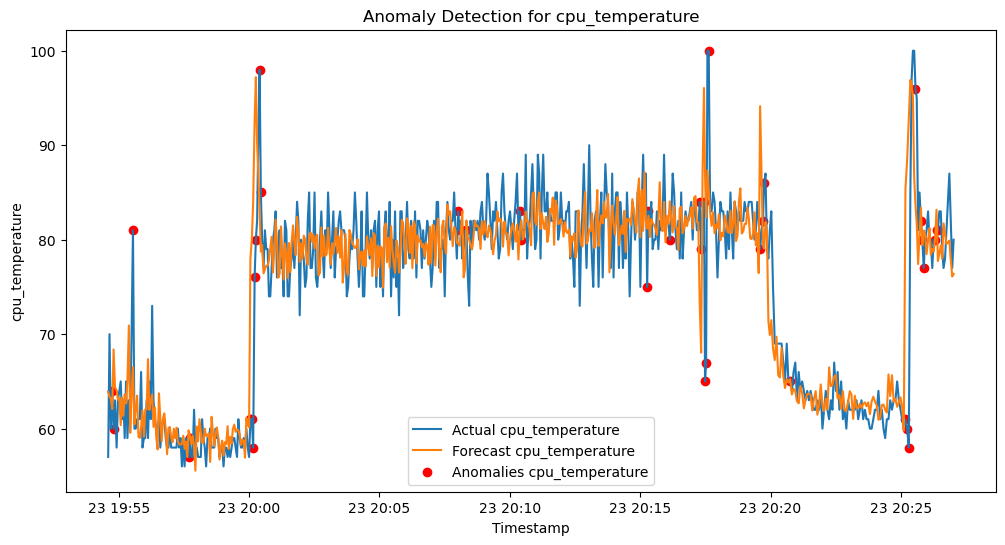

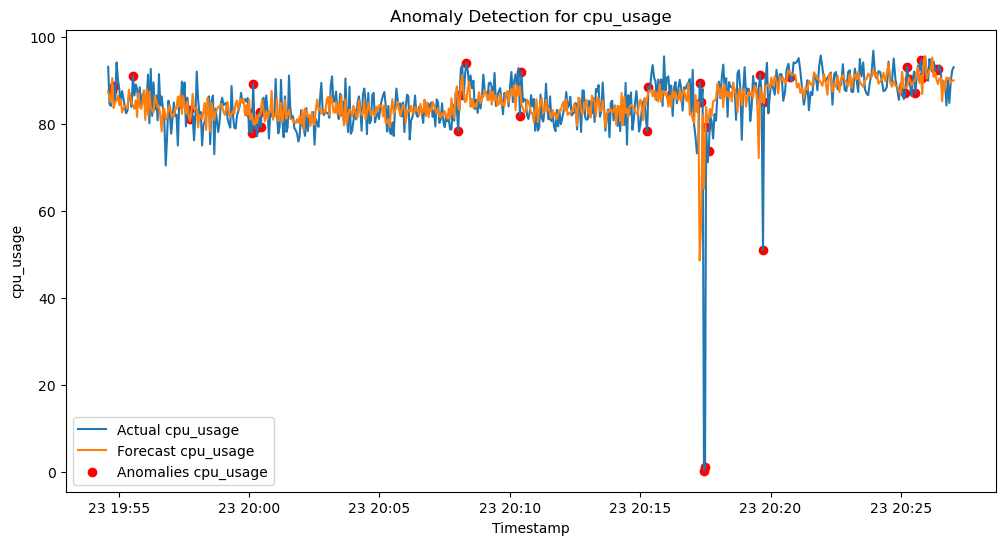

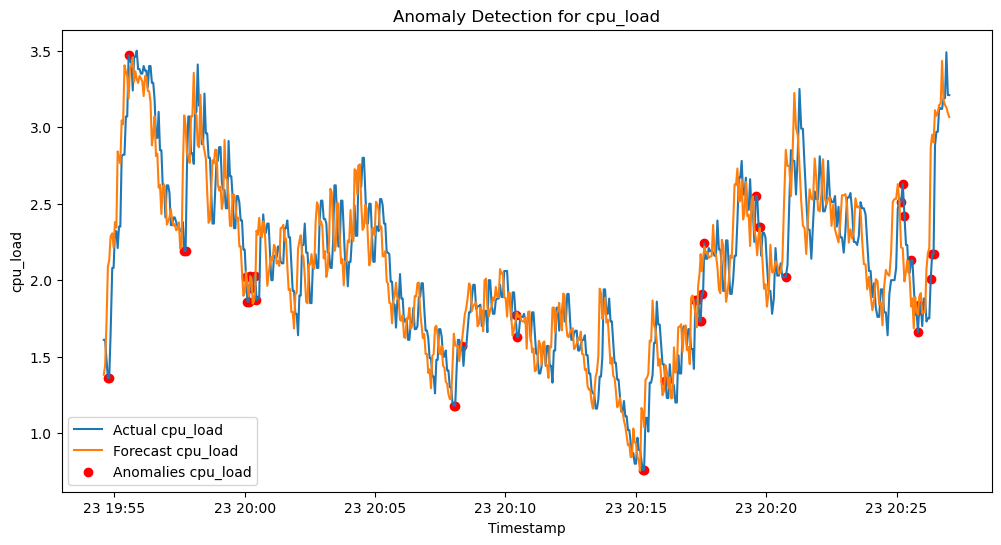

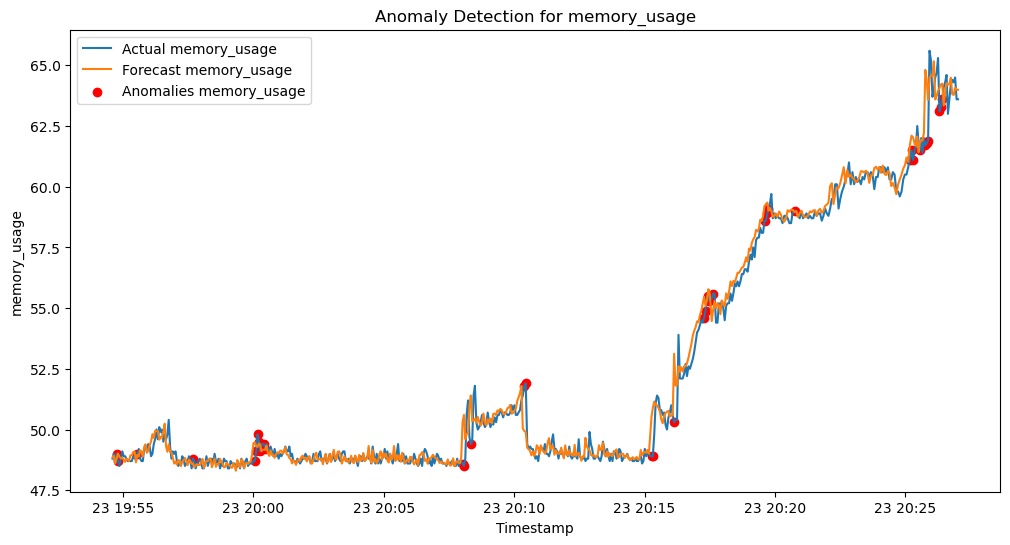

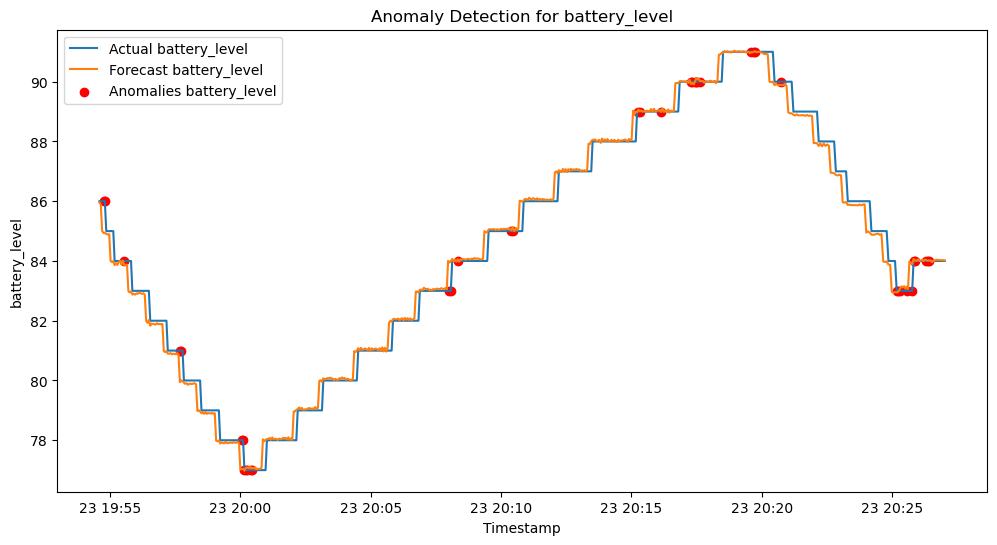

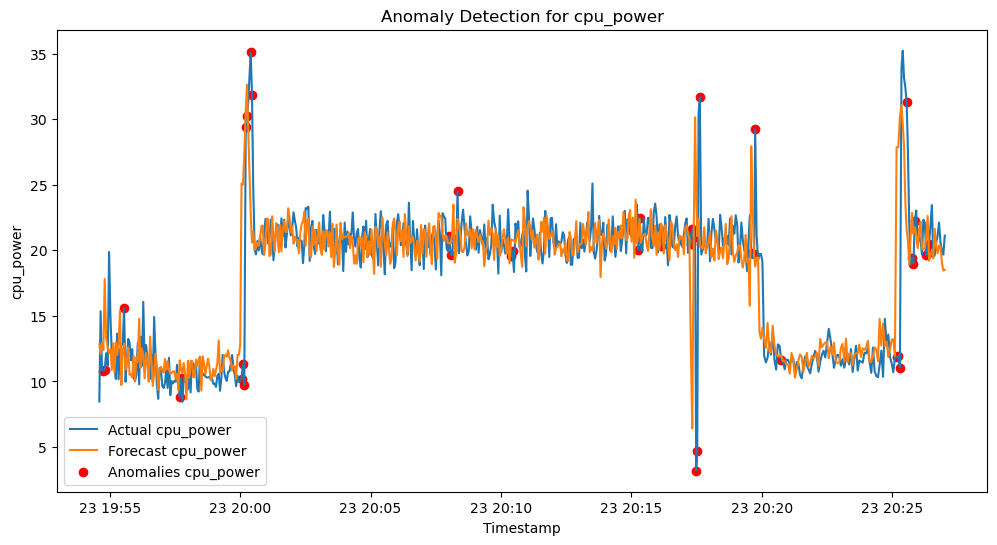

In [8]:
import matplotlib.pyplot as plt

for column in aligned_sensor_data.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(aligned_sensor_data.index.to_numpy(), aligned_sensor_data[column].to_numpy(), label=f'Actual {column}')
    plt.plot(var_forecast.index.to_numpy(), var_forecast[column].to_numpy(), label=f'Forecast {column}')
    
    # Filter the anomaly points to avoid plotting NaN values
    valid_anomalies = anomaly_points[column].dropna()
    plt.scatter(valid_anomalies.index.to_numpy(), valid_anomalies.to_numpy(), color='red', label=f'Anomalies {column}')
    
    plt.title(f'Anomaly Detection for {column}')
    plt.xlabel('Timestamp')
    plt.ylabel(column)
    plt.legend()
    plt.show()
